In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


In [2]:
marketing_campaign = pd.read_csv('marketing_campaign.csv', sep='\t')
marketing_campaign

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524        1957  Graduation         Single  58138.0        0   
1      2174        1954  Graduation         Single  46344.0        1   
2      4141        1965  Graduation       Together  71613.0        0   
3      6182        1984  Graduation       Together  26646.0        1   
4      5324        1981         PhD        Married  58293.0        1   
...     ...         ...         ...            ...      ...      ...   
2235  10870        1967  Graduation        Married  61223.0        0   
2236   4001        1946         PhD       Together  64014.0        2   
2237   7270        1981  Graduation       Divorced  56981.0        0   
2238   8235        1956      Master       Together  69245.0        0   
2239   9405        1954         PhD        Married  52869.0        1   

      Teenhome Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  \
0            0  04-09-2012       58       635  ...                  7   
1            1  08-03-2014       38        11  ...                  5   
2            0  21-08-2013       26       426  ...                  4   
3            0  10-02-2014       26        11  ...                  6   
4            0  19-01-2014       94       173  ...                  5   
...        ...         ...      ...       ...  ...                ...   
2235         1  13-06-2013       46       709  ...                  5   
2236         1  10-06-2014       56       406  ...                  7   
2237         0  25-01-2014       91       908  ...                  6   
2238         1  24-01-2014        8       428  ...                  3   
2239         1  15-10-2012       40        84  ...                  7   

      AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                0             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2235             0             0             0             0             0   
2236             0             0             0             1             0   
2237             0             1             0             0             0   
2238             0             0             0             0             0   
2239             0             0             0             0             0   

      Complain  Z_CostContact  Z_Revenue  Response  
0            0              3         11         1  
1            0              3         11         0  
2            0              3         11         0  
3            0              3         11         0  
4            0              3         11         0  
...        ...            ...        ...       ...  
2235         0              3         11         0  
2236         0              3         11         0  
2237         0              3         11         0  
2238         0              3         11         0  
2239         0              3         11         1  

[2240 rows x 29 columns]

Null values in income column.


In [4]:
marketing_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
marketing_campaign['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [6]:
marketing_campaign['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [7]:
marketing_campaign = marketing_campaign.dropna().reset_index(drop=True)

In [8]:
# Most likely, the dataset was assembled a long time ago, but we will not tell anyone
today_date = dt.date(2020,1,30)

# I would like to know how many days customers use our services
marketing_campaign['Dt_Customer'] = pd.to_datetime(marketing_campaign['Dt_Customer'],format='mixed')
marketing_campaign['customer_days'] = pd.to_datetime(today_date) - marketing_campaign['Dt_Customer']
marketing_campaign['customer_days'] = marketing_campaign['customer_days'].dt.days

# Calculating customer's age
marketing_campaign['customer_age'] = today_date.year - marketing_campaign['Year_Birth']

# The amount of purchases will make it easier to divide customers into groups
marketing_campaign['total_spent'] = marketing_campaign['MntWines'] + \
                                    marketing_campaign['MntFruits'] + \
                                    marketing_campaign['MntMeatProducts'] + \
                                    marketing_campaign['MntFishProducts'] + \
                                    marketing_campaign['MntSweetProducts'] + \
                                    marketing_campaign['MntGoldProds']

marketing_campaign['total_purchases'] = marketing_campaign['NumWebPurchases'] + \
                                        marketing_campaign['NumCatalogPurchases'] + \
                                        marketing_campaign['NumStorePurchases'] 

marketing_campaign['mean_goods_price'] = marketing_campaign['total_spent'] / marketing_campaign['total_purchases']

# It is worth determining how successful campaigns are in general
marketing_campaign['total_accepted_cmp'] = marketing_campaign['AcceptedCmp1'] + \
                                           marketing_campaign['AcceptedCmp2'] + \
                                           marketing_campaign['AcceptedCmp3'] + \
                                           marketing_campaign['AcceptedCmp4'] + \
                                           marketing_campaign['AcceptedCmp5'] + \
                                           marketing_campaign['Response']

for i in range(1,6):
    marketing_campaign['AcceptedCmp%s' % i] = marketing_campaign['AcceptedCmp%s' % i].replace({0:'Not accepted',
                                                                                             1:'Accepted'})

marketing_campaign['Response'] = marketing_campaign['Response'].replace({0:'Not accepted',
                                                                         1:'Accepted'})

# Children are children
marketing_campaign['total_childrens'] = marketing_campaign['Kidhome'] + marketing_campaign['Teenhome']

marketing_campaign['single_together'] = marketing_campaign['Marital_Status'].replace({'Single':1,
                                                                                      'Divorced':1,
                                                                                      'Widow':1,
                                                                                      'Alone':1,
                                                                                      'Absurd':1, 
                                                                                      'YOLO':1, 
                                                                                      'Together':2, 
                                                                                      'Married':2})

marketing_campaign['family_size'] = marketing_campaign['single_together'] + marketing_campaign['total_childrens']

marketing_campaign['parent'] = marketing_campaign['total_childrens'].map(lambda x: 0 if x == 0 else 1)

marketing_campaign['graduate'] = marketing_campaign['Education'].replace({'2n Cycle':0,
                                                                          'Basic':0,
                                                                          'Graduation':1,
                                                                          'Master':2,
                                                                          'PhD':2})

need_drop_1 = ['Year_Birth', 'Marital_Status', 'Kidhome', 'Teenhome', 'Dt_Customer', 
               'Z_CostContact', 'Z_Revenue',  'Complain', 'Recency']

marketing_campaign = marketing_campaign.drop(need_drop_1, axis=1)

C:\Users\Varun Sayam\AppData\Local\Temp\ipykernel_3120\2260261836.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  marketing_campaign['single_together'] = marketing_campaign['Marital_Status'].replace({'Single':1,
C:\Users\Varun Sayam\AppData\Local\Temp\ipykernel_3120\2260261836.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  marketing_campaign['graduate'] = marketing_campaign['Education'].replace({'2n Cycle':0,


 checking outliers

In [10]:
marketing_campaign.describe()

ID         Income     MntWines    MntFruits  MntMeatProducts  \
count   2216.000000    2216.000000  2216.000000  2216.000000      2216.000000   
mean    5588.353339   52247.251354   305.091606    26.356047       166.995939   
std     3249.376275   25173.076661   337.327920    39.793917       224.283273   
min        0.000000    1730.000000     0.000000     0.000000         0.000000   
25%     2814.750000   35303.000000    24.000000     2.000000        16.000000   
50%     5458.500000   51381.500000   174.500000     8.000000        68.000000   
75%     8421.750000   68522.000000   505.000000    33.000000       232.250000   
max    11191.000000  666666.000000  1493.000000   199.000000      1725.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count      2216.000000       2216.000000   2216.000000        2216.000000   
mean         37.637635         27.028881     43.965253           2.323556   
std          54.752082         41.072046     51.815414           1.923716   
min           0.000000          0.000000      0.000000           0.000000   
25%           3.000000          1.000000      9.000000           1.000000   
50%          12.000000          8.000000     24.500000           2.000000   
75%          50.000000         33.000000     56.000000           3.000000   
max         259.000000        262.000000    321.000000          15.000000   

       NumWebPurchases  ...  customer_age  total_spent  total_purchases  \
count      2216.000000  ...   2216.000000  2216.000000      2216.000000   
mean          4.085289  ...     51.179603   607.075361        12.557310   
std           2.740951  ...     11.985554   602.900476         7.204611   
min           0.000000  ...     24.000000     5.000000         0.000000   
25%           2.000000  ...     43.000000    69.000000         6.000000   
50%           4.000000  ...     50.000000   396.500000        12.000000   
75%           6.000000  ...     61.000000  1048.000000        18.000000   
max          27.000000  ...    127.000000  2525.000000        32.000000   

       mean_goods_price  total_accepted_cmp  total_childrens  single_together  \
count       2216.000000         2216.000000      2216.000000      2216.000000   
mean                inf            0.448556         0.947202         1.645307   
std                 NaN            0.892440         0.749062         0.478528   
min            2.666667            0.000000         0.000000         1.000000   
25%           13.000000            0.000000         0.000000         1.000000   
50%           29.966667            0.000000         1.000000         2.000000   
75%           50.250000            1.000000         1.000000         2.000000   
max                 inf            5.000000         3.000000         2.000000   

       family_size       parent     graduate  
count  2216.000000  2216.000000  2216.000000  
mean      2.592509     0.714350     1.267148  
std       0.905722     0.451825     0.652084  
min       1.000000     0.000000     0.000000  
25%       2.000000     0.000000     1.000000  
50%       3.000000     1.000000     1.000000  
75%       3.000000     1.000000     2.000000  
max       5.000000     1.000000     2.000000  

[8 rows x 24 columns]

In [11]:
marketing_campaign[marketing_campaign['mean_goods_price'] > 10**9]

ID   Education    Income  MntWines  MntFruits  MntMeatProducts  \
642    5555  Graduation  153924.0         1          1                1   
968    3955  Graduation    4861.0         2          1                1   
1232   6862  Graduation    1730.0         1          1                3   
1507  11110  Graduation    3502.0         2          1                1   
1829   9931         PhD    4023.0         5          0                1   
2109  11181         PhD  156924.0         2          1                2   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  ...  \
642                 1                 1             1                  0  ...   
968                 1                 0             1                  0  ...   
1232                1                 1             1                 15  ...   
1507                0                 0             1                  0  ...   
1829                1                 1             1                 15  ...   
2109                1                 1             1                  0  ...   

      customer_age  total_spent  total_purchases  mean_goods_price  \
642             45            6                0               inf   
968             55            6                0               inf   
1232            49            8                0               inf   
1507            47            5                0               inf   
1829            57            9                0               inf   
2109            71            8                0               inf   

     total_accepted_cmp total_childrens single_together family_size parent  \
642                   0               0               1           1      0   
968                   0               0               1           1      0   
1232                  0               0               1           1      0   
1507                  0               1               1           2      1   
1829                  0               2               2           4      1   
2109                  0               0               2           2      0   

     graduate  
642         1  
968         1  
1232        1  
1507        1  
1829        2  
2109        2  

[6 rows x 31 columns]

The income and age of some clients is high.

In [13]:
marketing_campaign = marketing_campaign[(marketing_campaign['Income'] < 500000) & \
                                        (marketing_campaign['customer_age'] < 100) & \
                                        (marketing_campaign['mean_goods_price'] < 10**9)
                                        ].reset_index(drop=True)

In [14]:
need_drop_2 = ['ID', 'Education', 'Response', 'AcceptedCmp1', 'AcceptedCmp2', 
               'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'total_accepted_cmp', 'single_together']

marketing_campaign_fstd = marketing_campaign.drop(need_drop_2, axis=1)

In [15]:
marketing_campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2206 non-null   int64  
 1   Education            2206 non-null   object 
 2   Income               2206 non-null   float64
 3   MntWines             2206 non-null   int64  
 4   MntFruits            2206 non-null   int64  
 5   MntMeatProducts      2206 non-null   int64  
 6   MntFishProducts      2206 non-null   int64  
 7   MntSweetProducts     2206 non-null   int64  
 8   MntGoldProds         2206 non-null   int64  
 9   NumDealsPurchases    2206 non-null   int64  
 10  NumWebPurchases      2206 non-null   int64  
 11  NumCatalogPurchases  2206 non-null   int64  
 12  NumStorePurchases    2206 non-null   int64  
 13  NumWebVisitsMonth    2206 non-null   int64  
 14  AcceptedCmp3         2206 non-null   object 
 15  AcceptedCmp4         2206 non-null   o

wine and meat are most traded goods but
Parents buy less meat.


<Axes: >

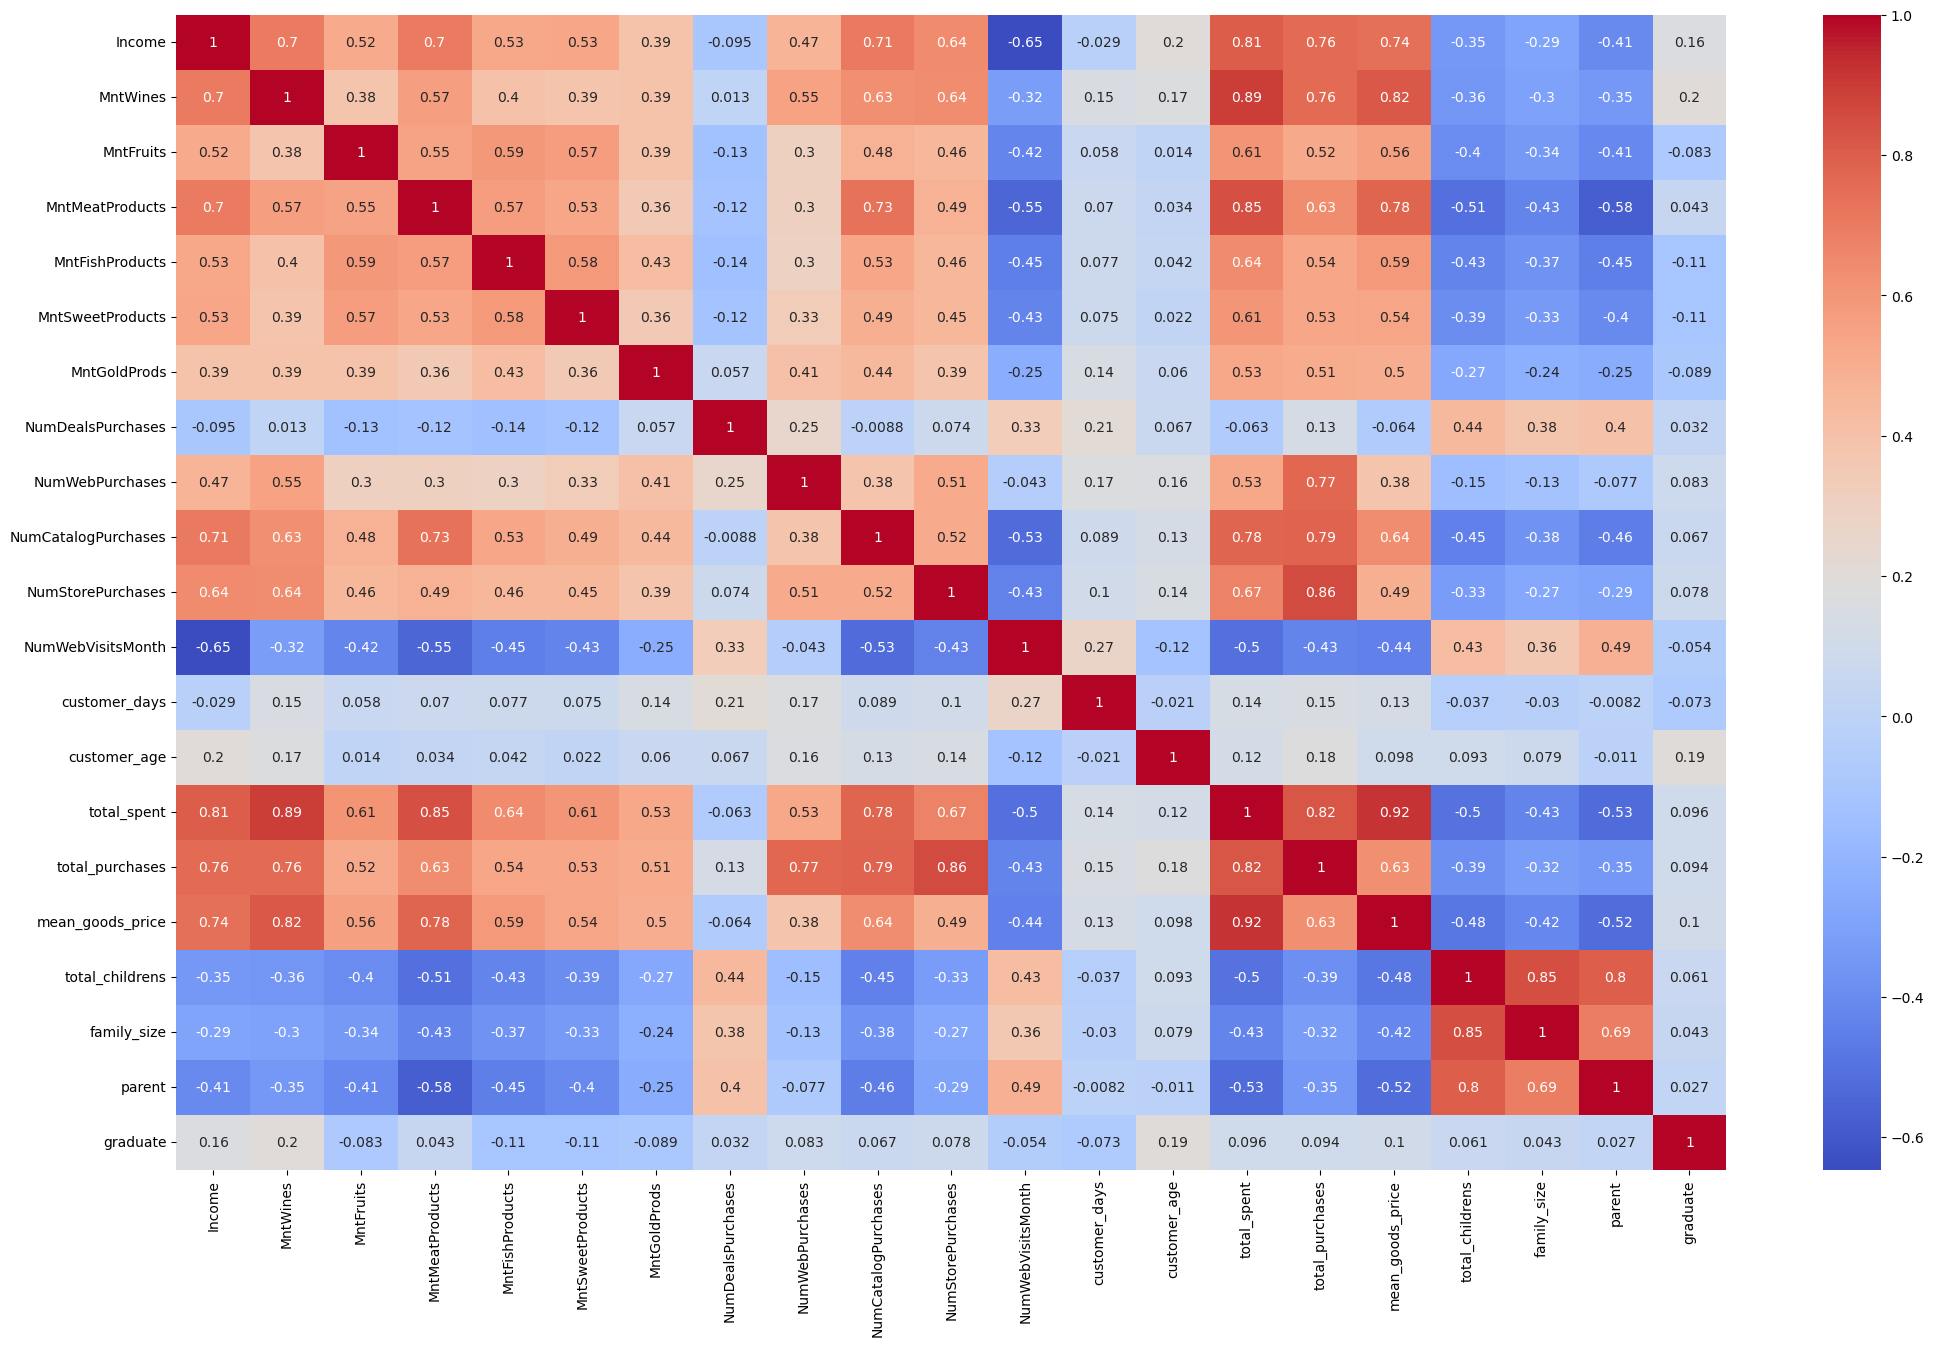

In [17]:
marketing_campaign_fstd.corr()
## plot the Correlation matrix
plt.figure(figsize=(25,15))
sns.heatmap(marketing_campaign_fstd.corr(),annot=True,cmap='coolwarm')

In [18]:
marketing_campaign_fstd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2206 non-null   float64
 1   MntWines             2206 non-null   int64  
 2   MntFruits            2206 non-null   int64  
 3   MntMeatProducts      2206 non-null   int64  
 4   MntFishProducts      2206 non-null   int64  
 5   MntSweetProducts     2206 non-null   int64  
 6   MntGoldProds         2206 non-null   int64  
 7   NumDealsPurchases    2206 non-null   int64  
 8   NumWebPurchases      2206 non-null   int64  
 9   NumCatalogPurchases  2206 non-null   int64  
 10  NumStorePurchases    2206 non-null   int64  
 11  NumWebVisitsMonth    2206 non-null   int64  
 12  customer_days        2206 non-null   int64  
 13  customer_age         2206 non-null   int64  
 14  total_spent          2206 non-null   int64  
 15  total_purchases      2206 non-null   i

In [19]:
std_scaler = StandardScaler()
std_scaler.fit(marketing_campaign_fstd)
marketing_campaign_scal = pd.DataFrame(std_scaler.transform(marketing_campaign_fstd), columns=marketing_campaign_fstd.columns )
marketing_campaign_scal

Income  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0     0.291407  0.974963   1.549059         1.687245         2.449823   
1    -0.264252 -0.874837  -0.638697        -0.719794        -0.652347   
2     0.926264  0.355399   0.568341        -0.180439         1.336691   
3    -1.192298 -0.874837  -0.563257        -0.657389        -0.506363   
4     0.298709 -0.394600   0.417461        -0.220556         0.150567   
...        ...       ...        ...              ...              ...   
2201  0.436752  1.194331   0.417461         0.064722         0.077575   
2202  0.568247  0.296110  -0.663843        -0.612815        -0.688844   
2203  0.236896  1.784251   0.543194         0.220734        -0.104906   
2204  0.814698  0.361328   0.090555         0.207362         0.771001   
2205  0.043165 -0.658434  -0.588404        -0.474633        -0.652347   

      MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0             1.480786      0.849960           0.361994         1.425194   
1            -0.635259     -0.735592          -0.168258        -1.132371   
2            -0.148812     -0.039496          -0.698509         1.425194   
3            -0.586614     -0.754928          -0.168258        -0.767004   
4            -0.002878     -0.561568           1.422497         0.329095   
...                ...           ...                ...              ...   
2201          2.210456      3.924386          -0.168258         1.790560   
2202         -0.659581     -0.696920           2.483000         1.425194   
2203         -0.367713     -0.387544          -0.698509        -0.767004   
2204          0.070089      0.327888          -0.168258         0.694461   
2205         -0.635259     -0.445552           0.361994        -0.401638   

      NumCatalogPurchases  ...  NumWebVisitsMonth  customer_days  \
0                2.500566  ...           0.714759       1.972244   
1               -0.573695  ...          -0.128878      -1.668745   
2               -0.232110  ...          -0.550697      -0.175337   
3               -0.915279  ...           0.292940      -1.926971   
4                0.109474  ...          -0.128878      -0.825206   
...                   ...  ...                ...            ...   
2201             0.109474  ...          -0.128878       0.121623   
2202            -0.232110  ...           0.714759      -1.944186   
2203             0.109474  ...           0.292940      -0.851028   
2204             0.792643  ...          -0.972515      -0.846725   
2205            -0.573695  ...           0.714759       1.158832   

      customer_age  total_spent  total_purchases  mean_goods_price  \
0         1.018496     1.673525         1.308371          1.195941   
1         1.274795    -0.966002        -1.197311         -1.024683   
2         0.335032     0.277398         1.029962          0.041549   
3        -1.288195    -0.922840        -0.918902         -0.955376   
4        -1.031896    -0.310270         0.194735         -0.246455   
...            ...          ...              ...               ...   
2201      0.164166     1.215343         0.473144          1.539015   
2202      1.958260    -0.273748         0.333940         -0.264515   
2203     -1.031896     1.049335         0.751553          1.044388   
2204      1.103929     0.388623         1.169167          0.086223   
2205      1.274795    -0.725290        -0.640492         -0.533984   

      total_childrens  family_size    parent  graduate  
0           -1.266906    -1.763261 -1.585162 -0.411142  
1            1.403705     0.447454  0.630850 -0.411142  
2           -1.266906    -0.657903 -1.585162 -0.411142  
3            0.068400     0.447454  0.630850 -0.411142  
4            0.068400     0.447454  0.630850  1.123510  
...               ...          ...       ...       ...  
2201         0.068400     0.447454  0.630850 -0.411142  
2202         2.739011     2.658170  0.630850  1.123510  
2203        -1.266906    -1.763261 -1.585162 -0

combining correlated columns

In [21]:
marketing_size = len(marketing_campaign_scal.columns)
pca = PCA(n_components=marketing_size)
pca_fit = pca.fit(marketing_campaign_scal)
PC_values = np.arange(marketing_size) + 1

var_ratio = pca.explained_variance_ratio_
#pca_colnames = ['marketing_campaign_fstd.columns' % i for i in PC_values]
pca_colnames = marketing_campaign_fstd.columns

marketing_pca_df = pd.DataFrame(pca.transform(marketing_campaign_scal), 
                                columns=(pca_colnames), 
                                index=marketing_campaign_scal.index)

In [22]:
fpca = 0
perc = np.zeros(shape=marketing_size)
for i in range(marketing_size):
    fpca += var_ratio[i] * 100
    perc[i] = fpca

In [23]:
var_ratio_df = pd.DataFrame([var_ratio, perc], columns=pca_colnames)
var_ratio_df

Income   MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0   0.438268   0.121129   0.071034         0.056342         0.041763   
1  43.826767  55.939635  63.043001        68.677195        72.853459   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0          0.040131      0.032410           0.031252         0.027912   
1         76.866516     80.107467          83.232687        86.023880   

   NumCatalogPurchases  ...  NumWebVisitsMonth  customer_days  customer_age  \
0             0.025989  ...           0.019395       0.018820      0.014523   
1            88.622809  ...          92.660997      94.542958     95.995282   

   total_spent  total_purchases  mean_goods_price  total_childrens  \
0     0.013068         0.011260          0.008008         0.005477   
1    97.302062        98.428091         99.228897        99.776563   

   family_size  parent  graduate  
0     0.002234     0.0       0.0  
1   100.000000   100.0     100.0  

[2 rows x 21 columns]

In [24]:
pca_colnames

Index(['Income', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'customer_days', 'customer_age', 'total_spent',
       'total_purchases', 'mean_goods_price', 'total_childrens', 'family_size',
       'parent', 'graduate'],
      dtype='object')

In [25]:
#marketing_80_df = marketing_pca_df.drop(['PCA_%s' % i for i in range(8,22)], axis=1)
marketing_80_df = marketing_pca_df.drop(['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts'
                                         ,'MntGoldProds','NumWebPurchases','NumCatalogPurchases','parent','graduate','total_childrens'
                                         ,'mean_goods_price','total_spent','customer_days','NumStorePurchases','NumDealsPurchases'],axis=1)
marketing_80_df

Income  NumWebVisitsMonth  customer_age  total_purchases  family_size
0     5.095900          -1.388591      0.742243        -0.303413    -0.180636
1    -3.127482          -0.032794      0.256423         0.088453    -0.197366
2     2.456121          -0.481757     -1.063531        -0.555902    -0.009957
3    -2.998929           0.076163      0.283526         0.082375    -0.041501
4    -0.384960          -0.140036     -0.084510        -0.277977    -0.004598
...        ...                ...           ...              ...          ...
2201  2.755913           1.147681     -0.155334        -0.110522    -0.130501
2202 -1.878735          -0.081265     -0.805098        -0.746412     0.029912
2203  2.611063           0.909132      0.874054        -0.063606     0.139858
2204  1.794893          -0.363791      0.346893         0.214554     0.146787
2205 -2.484767          -0.173043     -0.456452         0.034665     0.013031

[2206 rows x 5 columns]

elbow approach to get optimal cluster

In [27]:
distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(marketing_80_df)
    distortions.append(kmeanModel.inertia_)

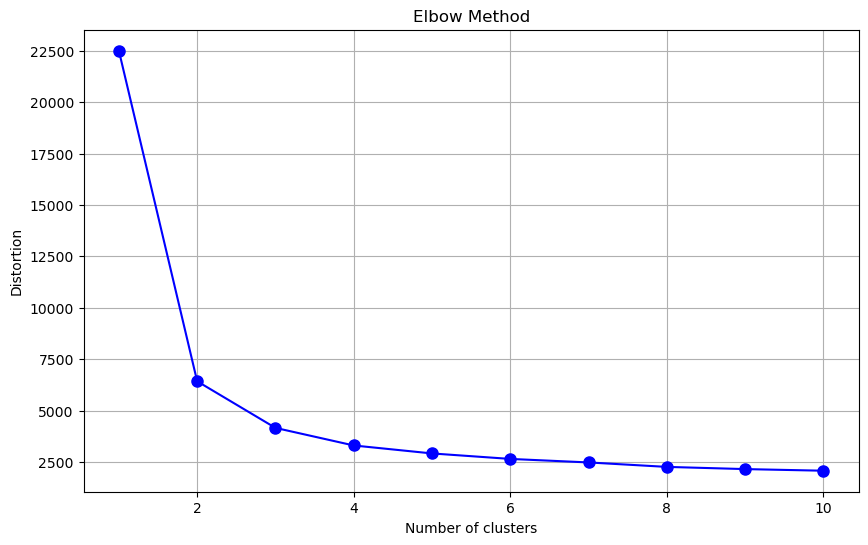

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bo-', markersize=8)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

Four clusters will be enough

In [30]:
AC = KMeans(n_clusters=4)

AC_clust = AC.fit_predict(marketing_80_df)
marketing_80_df['Clusters'] = AC_clust
marketing_80_df['Clusters'] = marketing_80_df['Clusters'].replace({0:'Group_1',
                                                                   1:'Group_2',
                                                                   2:'Group_3',
                                                                   3:'Group_4'})
#Adding the Clusters feature to the orignal dataframe.
marketing_campaign['Clusters'] = AC_clust
marketing_campaign['Clusters'] = marketing_campaign['Clusters'].replace({0:'Group_1',
                                                                         1:'Group_2',
                                                                         2:'Group_3',
                                                                         3:'Group_4'})
marketing_campaign = marketing_campaign.sort_values('Clusters')

marketing_campaign['single_together'] = marketing_campaign['single_together'].replace({1:'Single',
                                                                                       2:'Together'})

marketing_campaign['graduate'] = marketing_campaign['graduate'].replace({0:'Basic',
                                                                         1:'Graduation',
                                                                         2:'Master'})

colors = ['#20bf6b', '#fa8231', '#3867d6', '#eb3b5a']
cluster_names = ['Group_1', 'Group_2', 'Group_3', 'Group_4']
cluster_colors = {'Group_1':'#20bf6b', 'Group_2':'#fa8231', 'Group_3':'#3867d6', 'Group_4':'#eb3b5a'}

The algorithm splited into 4 clusters.

([<matplotlib.patches.Wedge at 0x1dfe338aad0>,
 [Text(-1.0966001837549795, 0.08641780481211715, 'Group_1'),
  Text(0.26945677805671664, -1.0664863078161357, 'Group_2'),
  Text(0.9572068896637033, 0.5419916700285525, 'Group_3'),
  Text(-0.20676237869877268, 1.0803931315751807, 'Group_4')],
 [Text(-0.5981455547754433, 0.047136984442972985, '19.7%'),
  Text(0.1469764243945727, -0.5817198042633467, '40.7%'),
  Text(0.5221128489074744, 0.2956318200155741, '17.9%'),
  Text(-0.11277947929023963, 0.589305344495553, '21.8%')])

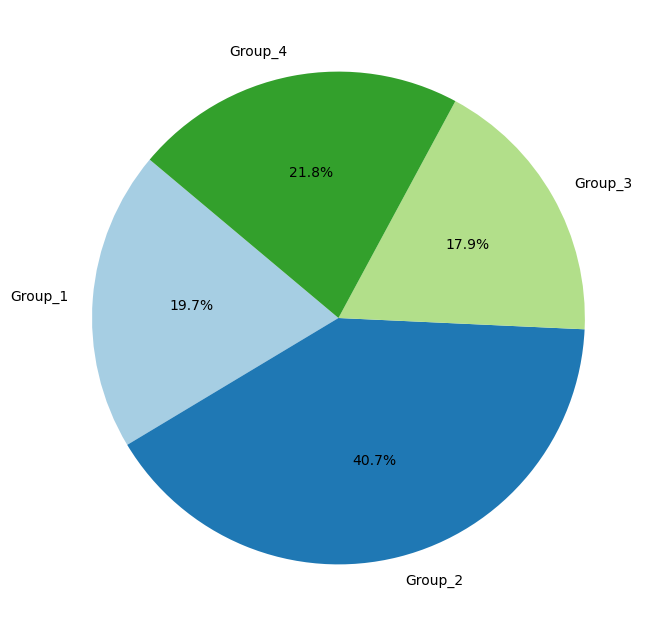

In [32]:
cluster_count = marketing_campaign['Clusters'].value_counts().sort_index()
plt.figure(figsize=(8, 8))
plt.pie(cluster_count, labels=cluster_count.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(cluster_count))))

The separation of customers into clusters is evident in the dependency of store spending on income. Although group 1 is of some relevance, the graph displays the typical relationship between these markers. While group 3's average number of things purchased is roughly comparable, this group's income is higher. This group needs more attention; it's likely that the firm doesn't supply the items required for them, or promotional businesses don't think about them.

Text(0, 0.5, 'Income')

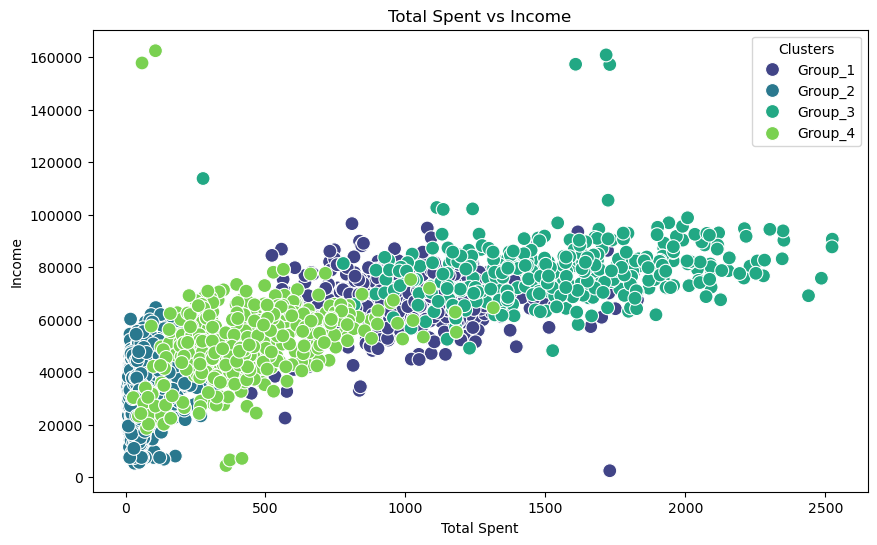

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=marketing_campaign, x='total_spent', y='Income', hue='Clusters', palette='viridis', s=100)
plt.title('Total Spent vs Income')
plt.xlabel('Total Spent')
plt.ylabel('Income')

Amoung groups 2 and 4,Group 2 buys expensive goods

Text(0, 0.5, 'Total Purchases')

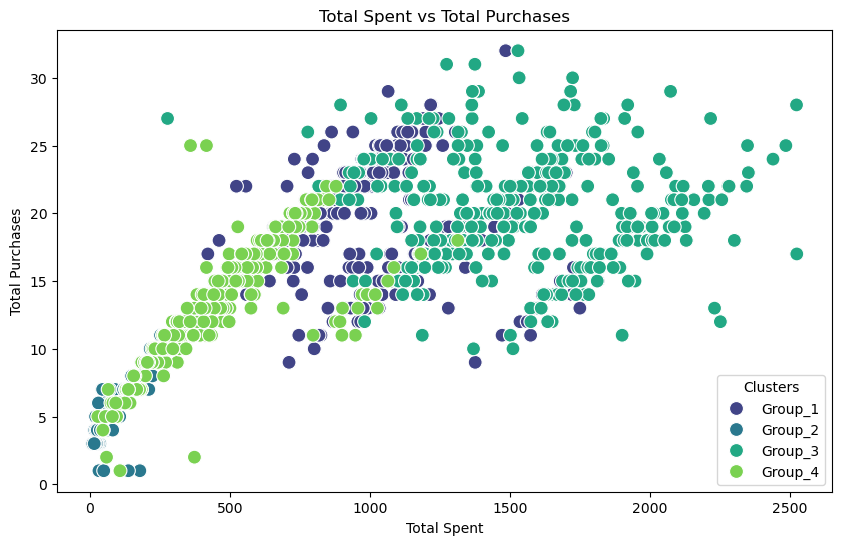

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=marketing_campaign, x='total_spent', y='total_purchases', hue='Clusters', palette='viridis', s=100)

plt.title('Total Spent vs Total Purchases')
plt.xlabel('Total Spent')
plt.ylabel('Total Purchases')

Text(0, 0.5, 'Total Purchases')

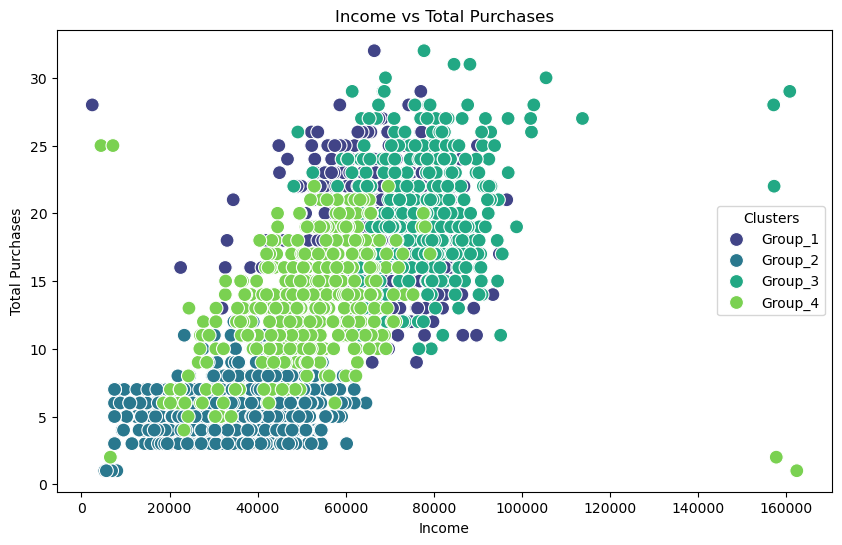

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=marketing_campaign, x='Income', y='total_purchases', hue='Clusters', palette='viridis', s=100)
plt.title('Income vs Total Purchases')
plt.xlabel('Income')
plt.ylabel('Total Purchases')

The group with the lowest income is the youngest.

C:\Users\Varun Sayam\AppData\Local\Temp\ipykernel_3120\398128955.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=marketing_campaign, y='customer_age', x='Clusters', palette='viridis')


Text(0, 0.5, 'Customer Age')

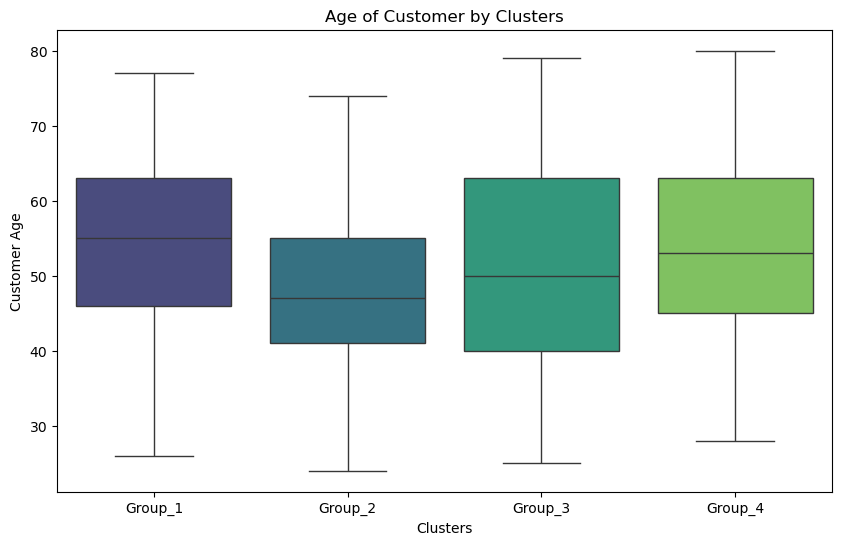

In [39]:
# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=marketing_campaign, y='customer_age', x='Clusters', palette='viridis')
plt.title('Age of Customer by Clusters')
plt.xlabel('Clusters')
plt.ylabel('Customer Age')

Text(0, 0.5, 'Count')

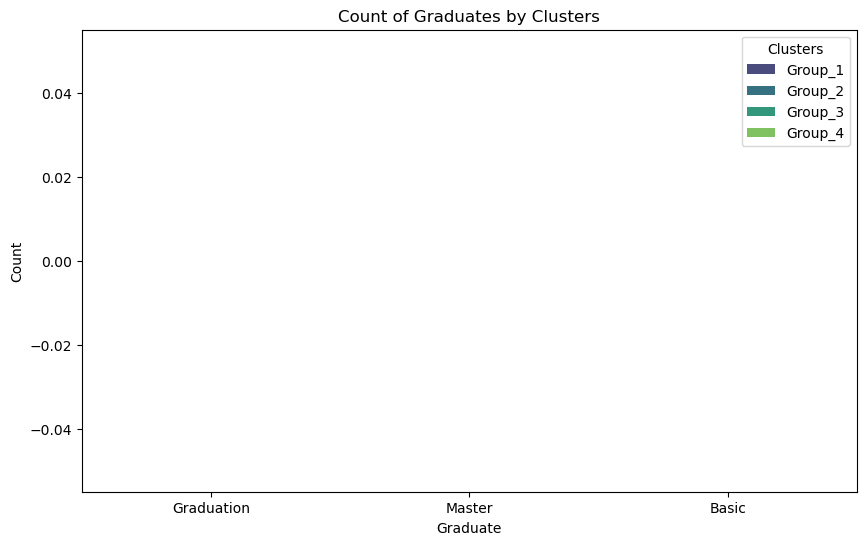

In [40]:
gr_bar_df = marketing_campaign.value_counts(['graduate', 'Clusters']
                                            ).reset_index().sort_values(by='Clusters')
gr_bar_df['Clusters'] = gr_bar_df['Clusters'].astype(str)
plt.figure(figsize=(10, 6))
sns.barplot(gr_bar_df, x='graduate', y=0, hue='Clusters', palette='viridis')

# Add title and labels
plt.title('Count of Graduates by Clusters')
plt.xlabel('Graduate')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

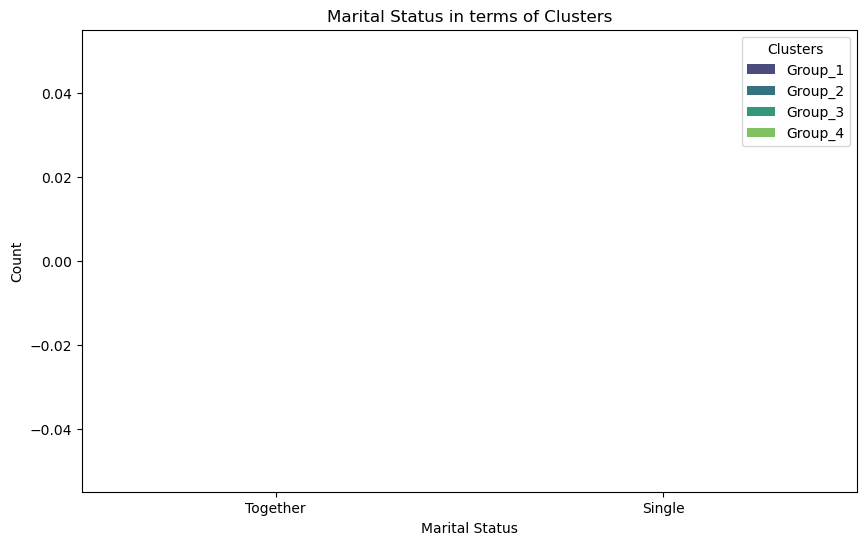

In [41]:
st_bar_df = marketing_campaign.value_counts(['single_together', 'Clusters']
                                            ).reset_index().sort_values(by='Clusters')
st_bar_df['Clusters'] = st_bar_df['Clusters'].astype(str)
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=st_bar_df, x='single_together', y=0, hue='Clusters', palette='viridis')

# Add title and labels
plt.title('Marital Status in terms of Clusters')
plt.xlabel('Marital Status')
plt.ylabel('Count')

Considering group 1, we can presume that the company offers little products for families with kids; therefore, you may want to think about ways to increase the selection in order to draw in this market.

Text(0, 0.5, 'Count')

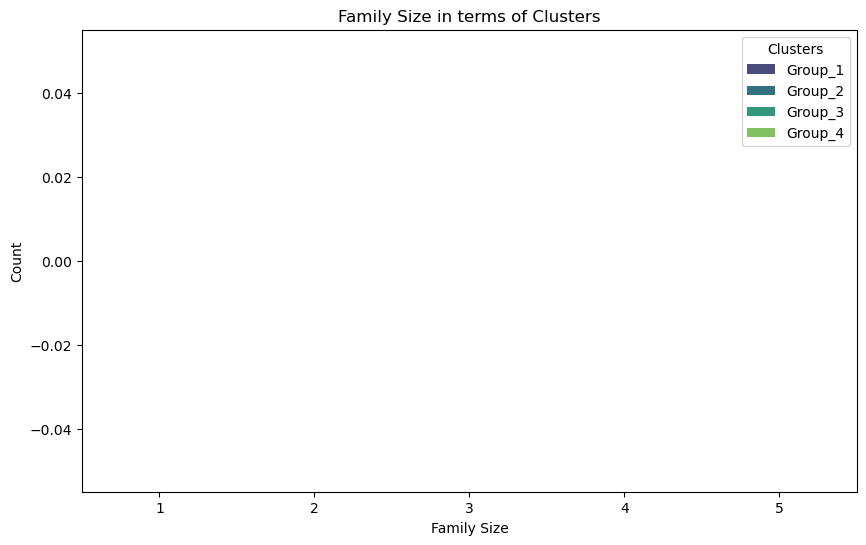

In [43]:
fs_bar_df = marketing_campaign.value_counts(['family_size', 'Clusters']
                                            ).reset_index().sort_values(by='Clusters')
fs_bar_df['Clusters'] = fs_bar_df['Clusters'].astype(str)

plt.figure(figsize=(10, 6))
sns.barplot(data=fs_bar_df, x='family_size', y=0, hue='Clusters', palette='viridis')

# Add title and labels
plt.title('Family Size in terms of Clusters')
plt.xlabel('Family Size')
plt.ylabel('Count')

Wine is the most traded commodity. All products have almost the same cluster distribution, however meat products are worth mentioning. The highest income group is the primary user of these things. Meat goods are probably more expensive here than they are in other places.

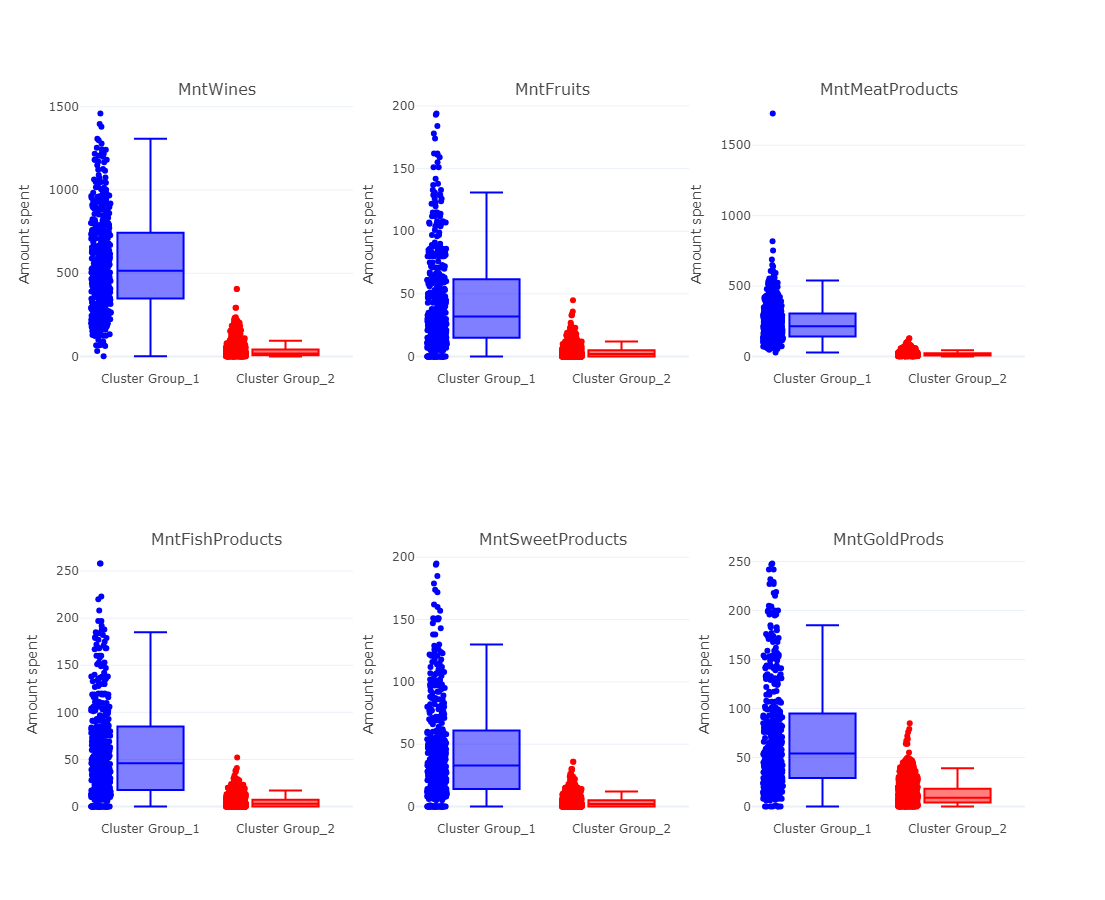

In [45]:
# Define product columns and cluster positions
cluster_pars = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
box_pos_r = [1, 1, 1, 2, 2, 2]
box_pos_c = [1, 2, 3, 1, 2, 3]
cluster_names = marketing_campaign['Clusters'].unique()
colors = ['blue', 'red']

# Create subplots
fig_box = make_subplots(rows=2, cols=3, subplot_titles=cluster_pars)

# Add box plots for each product and cluster
for c_p, b_p_r, b_p_c in zip(cluster_pars, box_pos_r, box_pos_c):
    for c_n, c_c in zip(cluster_names, colors):
        m_c_c = marketing_campaign[marketing_campaign['Clusters'] == c_n]
        fig_box.add_trace(go.Box(
            y=m_c_c[c_p],
            name=f'Cluster {c_n}',
            marker_color=c_c,
            boxpoints='all'
        ), row=b_p_r, col=b_p_c)
    
    fig_box.update_yaxes(title_text='Amount spent', row=b_p_r, col=b_p_c)
    
    # Update layout and show plot
fig_box.update_layout(
    height=900,
    width=1200,
    font_color='#484848',
    template='plotly_white',
    showlegend=False
)

fig_box.show()


It is interesting to note that the wealthiest income group is the least likely to visit the site the least and purchase things at a discount. It could be worthwhile to think about ways to draw this audience's attention to the website.

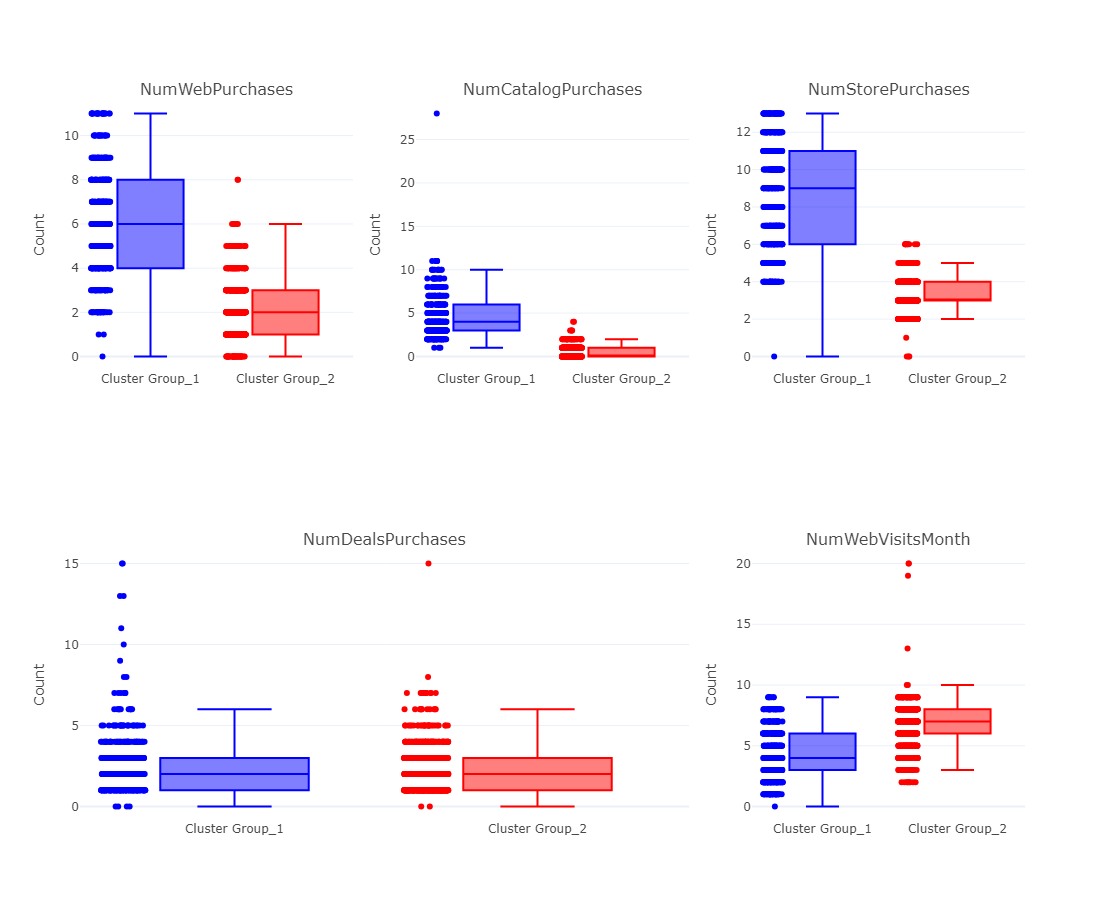

In [47]:
cluster_nums = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumDealsPurchases', 'NumWebVisitsMonth']
num_pos_r = [1, 1, 1, 2, 2]
num_pos_c = [1, 2, 3, 1, 3]
cluster_names = marketing_campaign['Clusters'].unique()
colors = ['blue', 'red']  # Example colors for clusters

# Create subplots with specific layout
fig_num = make_subplots(
    rows=2, cols=3, 
    subplot_titles=cluster_nums, 
    specs=[[{}, {}, {}], [{"colspan": 2}, None, {"colspan": 1}]]
)

# Add box plots for each metric and cluster
for metric, row, col in zip(cluster_nums, num_pos_r, num_pos_c):
    for cluster, color in zip(cluster_names, colors):
        subset = marketing_campaign[marketing_campaign['Clusters'] == cluster]
        fig_num.add_trace(
            go.Box(
                y=subset[metric],
                name=f'Cluster {cluster}',
                marker_color=color,
                boxpoints='all'
            ),
            row=row,
            col=col
        )
    fig_num.update_yaxes(title_text='Count', row=row, col=col)

# Update layout and show plot
fig_num.update_layout(
    height=900,
    width=1200,
    font_color='#484848',
    template='plotly_white',
    showlegend=False
)

fig_num.show()

Group 2, which has the largest income, has the highest level of interest in campaigns. These campaigns are probably designed with these clients in mind.

Text(0, 0.5, 'Count')

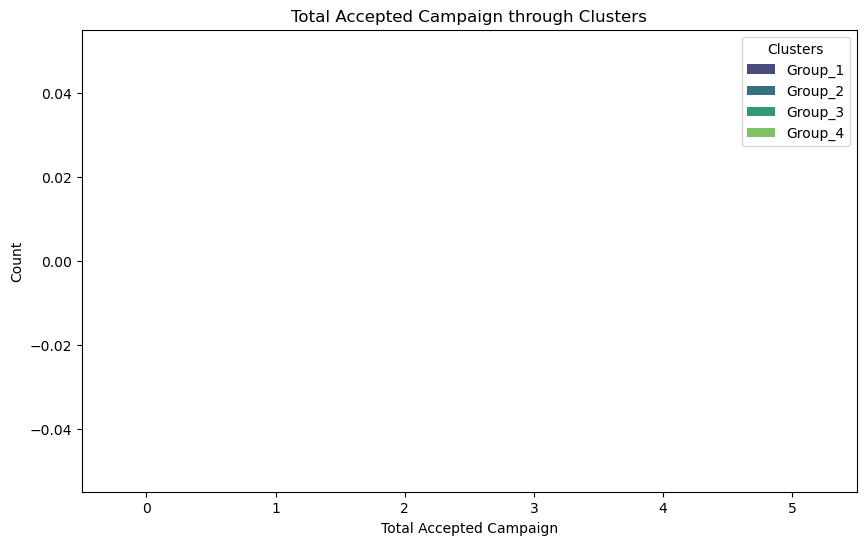

In [49]:
tc_bar_df = marketing_campaign.value_counts(['total_accepted_cmp', 'Clusters']
                                            ).reset_index().sort_values(by='Clusters')
tc_bar_df['Clusters'] = tc_bar_df['Clusters'].astype(str)
plt.figure(figsize=(10, 6))
sns.barplot(data=tc_bar_df, x='total_accepted_cmp', y=0, hue='Clusters', palette='viridis')

# Add title and labels
plt.title('Total Accepted Campaign through Clusters')
plt.xlabel('Total Accepted Campaign')
plt.ylabel('Count')

We may probably infer that the most successful campaign to date brought in a record number of customers. Campaigns ought to, in my opinion, concentrate on both group 2 and group 4. Although this group is less affluent, has a single child, and enjoys discounts, it is nonetheless just as devoted as group 2.

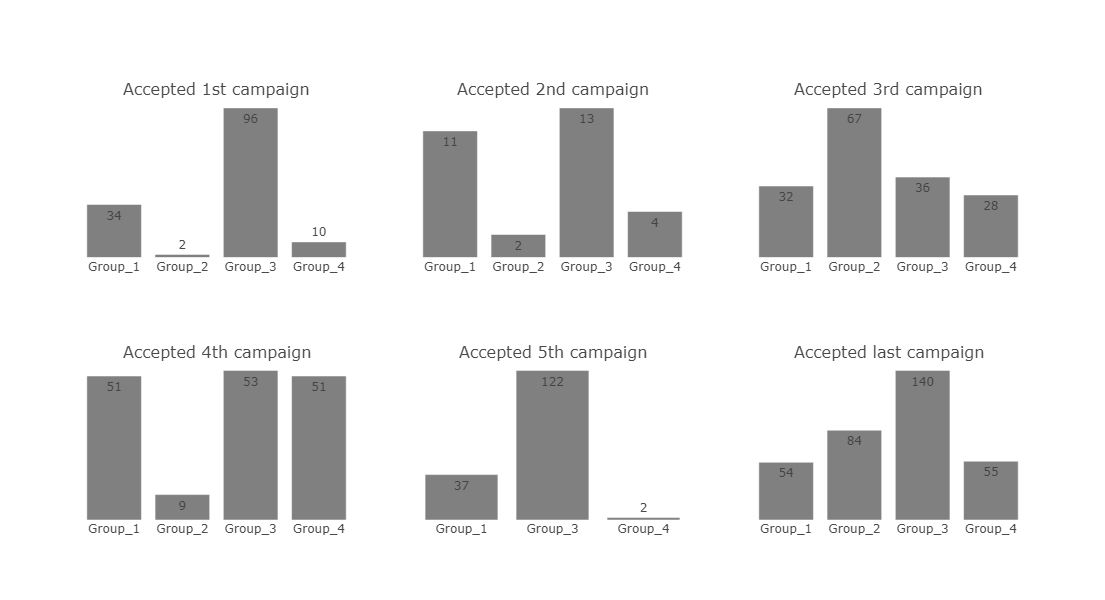

In [51]:
bar_titles = (
    'Accepted 1st campaign', 'Accepted 2nd campaign', 'Accepted 3rd campaign', 
    'Accepted 4th campaign', 'Accepted 5th campaign', 'Accepted last campaign'
)
bar_x = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
bar_pos_r = [1, 1, 1, 2, 2, 2]
bar_pos_c = [1, 2, 3, 1, 2, 3]
cluster_names = marketing_campaign['Clusters'].unique()
cluster_colors = {1: 'blue', 2: 'red'}  # Example color mapping for clusters

# Create subplots
fig_bar = make_subplots(
    rows=2, cols=3, 
    subplot_titles=bar_titles
)

# Add bar plots
for b_x, b_p_r, b_p_c in zip(bar_x, bar_pos_r, bar_pos_c):
    # Calculate counts of accepted responses per cluster
    mark_calc = marketing_campaign[marketing_campaign[b_x] == 'Accepted']['Clusters'].value_counts().sort_index()
    # Add bars for each cluster
    for cluster, count in mark_calc.items():
        fig_bar.add_trace(
            go.Bar(
                x=[cluster], 
                y=[count],
                text=str(count),
                marker_color=cluster_colors.get(cluster, 'gray')
            ), 
            col=b_p_c, 
            row=b_p_r
        )
    fig_bar.update_yaxes(visible=False, col=b_p_c, row=b_p_r)

# Update layout and show plot
fig_bar.update_layout(
    height=600,
    width=1000,
    font_color='#484848',
    template='plotly_white',
    showlegend=False
)

fig_bar.show()

In [52]:
marketing_campaign[marketing_campaign['Clusters'] == 'Group_1'].describe()

ID        Income     MntWines   MntFruits  MntMeatProducts  \
count    435.000000    435.000000   435.000000  435.000000       435.000000   
mean    5592.372414  66526.735632   556.986207   43.928736       243.772414   
std     3243.014713  10811.826984   292.455841   39.868181       146.461084   
min        1.000000   2447.000000     1.000000    0.000000        29.000000   
25%     2853.000000  60972.000000   348.500000   15.000000       142.000000   
50%     5376.000000  66835.000000   515.000000   32.000000       215.000000   
75%     8693.000000  73747.000000   742.500000   61.500000       305.000000   
max    11101.000000  96547.000000  1459.000000  194.000000      1725.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count       435.000000        435.000000    435.000000         435.000000   
mean         59.793103         45.059770     69.993103           2.542529   
std          52.142338         40.713862     55.813114           1.984945   
min           0.000000          0.000000      0.000000           0.000000   
25%          18.000000         14.000000     29.000000           1.000000   
50%          46.000000         33.000000     54.000000           2.000000   
75%          85.000000         61.000000     95.000000           3.000000   
max         258.000000        195.000000    248.000000          15.000000   

       NumWebPurchases  ...  NumWebVisitsMonth  customer_days  customer_age  \
count       435.000000  ...         435.000000     435.000000    435.000000   
mean          6.075862  ...           4.402299    2428.475862     54.234483   
std           2.403193  ...           2.098166     223.300177     11.067044   
min           0.000000  ...           0.000000    1882.000000     26.000000   
25%           4.000000  ...           3.000000    2263.000000     46.000000   
50%           6.000000  ...           4.000000    2434.000000     55.000000   
75%           8.000000  ...           6.000000    2585.500000     63.000000   
max          11.000000  ...           9.000000    2944.000000     77.000000   

       total_spent  total_purchases  mean_goods_price  total_accepted_cmp  \
count   435.000000       435.000000        435.000000          435.000000   
mean   1019.533333        19.409195         54.958702            0.503448   
std     268.715841         4.006666         20.299120            0.968091   
min     406.000000         9.000000         23.772727            0.000000   
25%     834.500000        16.000000         40.686275            0.000000   
50%     989.000000        20.000000         45.083333            0.000000   
75%    1158.500000        22.000000         69.800000            1.000000   
max    1829.000000        32.000000        152.888889            5.000000   

       total_childrens  family_size      parent  
count       435.000000   435.000000  435.000000  
mean          0.744828     2.400000    0.685057  
std           0.569331     0.756538    0.465028  
min           0.000000     1.000000    0.000000  
25%           0.000000     2.000000    0.000000  
50%           1.000000     2.000000    1.000000  
75%           1.000000     3.000000    1.000000  
max           3.000000     5.000000    1.000000  

[8 rows x 22 columns]

In [53]:
marketing_campaign[marketing_campaign['Clusters'] == 'Group_2'].describe()

ID        Income    MntWines   MntFruits  MntMeatProducts  \
count    897.000000    897.000000  897.000000  897.000000       897.000000   
mean    5661.255295  33479.183946   35.714604    3.704571        18.481605   
std     3235.436950  11529.219843   48.157908    5.193866        18.059053   
min        9.000000   5305.000000    0.000000    0.000000         0.000000   
25%     2811.000000  25252.000000    7.000000    0.000000         7.000000   
50%     5623.000000  33629.000000   18.000000    2.000000        13.000000   
75%     8416.000000  41275.000000   42.000000    5.000000        22.000000   
max    11188.000000  64587.000000  406.000000   45.000000       129.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count       897.000000        897.000000    897.000000         897.000000   
mean          5.345596          3.783724     12.576366           2.137124   
std           6.693119          5.082801     12.531345           1.404765   
min           0.000000          0.000000      0.000000           0.000000   
25%           0.000000          0.000000      4.000000           1.000000   
50%           3.000000          2.000000      9.000000           2.000000   
75%           7.000000          5.000000     18.000000           3.000000   
max          52.000000         36.000000     85.000000          15.000000   

       NumWebPurchases  ...  NumWebVisitsMonth  customer_days  customer_age  \
count       897.000000  ...         897.000000     897.000000    897.000000   
mean          1.975474  ...           6.591973    2359.956522     48.274247   
std           1.182773  ...           1.736126     231.944015     10.659112   
min           0.000000  ...           2.000000    1881.000000     24.000000   
25%           1.000000  ...           6.000000    2173.000000     41.000000   
50%           2.000000  ...           7.000000    2354.000000     47.000000   
75%           3.000000  ...           8.000000    2536.000000     55.000000   
max           8.000000  ...          20.000000    2944.000000     74.000000   

       total_spent  total_purchases  mean_goods_price  total_accepted_cmp  \
count   897.000000       897.000000        897.000000          897.000000   
mean     79.606466         5.481605         13.094811            0.182832   
std      67.297150         2.022183          9.190548            0.462929   
min       8.000000         1.000000          2.666667            0.000000   
25%      36.000000         4.000000          8.000000            0.000000   
50%      57.000000         5.000000         11.500000            0.000000   
75%      97.000000         6.000000         16.666667            0.000000   
max     444.000000        15.000000        178.000000            2.000000   

       total_childrens  family_size      parent  
count       897.000000   897.000000  897.000000  
mean          1.361204     3.024526    0.931996  
std           0.680541     0.819312    0.251894  
min           0.000000     1.000000    0.000000  
25%           1.000000     2.000000    1.000000  
50%           1.000000     3.000000    1.000000  
75%           2.000000     4.000000    1.000000  
max           3.000000     5.000000    1.000000  

[8 rows x 22 columns]

In [54]:
marketing_campaign[marketing_campaign['Clusters'] == 'Group_3'].describe()

ID         Income     MntWines   MntFruits  MntMeatProducts  \
count    394.000000     394.000000   394.000000  394.000000       394.000000   
mean    5636.710660   78684.827411   688.370558   73.700508       527.604061   
std     3213.057424   11530.877988   324.638816   52.590614       242.336077   
min        0.000000   48192.000000     1.000000    0.000000         3.000000   
25%     2933.000000   71979.250000   434.000000   27.000000       374.500000   
50%     5537.000000   78878.000000   674.000000   63.000000       500.500000   
75%     8487.750000   83819.250000   918.750000  111.000000       705.500000   
max    11112.000000  160803.000000  1493.000000  199.000000      1725.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count       394.000000        394.000000    394.000000         394.000000   
mean        109.025381         76.426396     83.807107           1.230964   
std          68.150331         54.513727     63.948479           1.326940   
min           0.000000          0.000000      0.000000           0.000000   
25%          50.000000         31.000000     33.000000           1.000000   
50%          98.500000         66.000000     64.500000           1.000000   
75%         159.750000        115.750000    126.000000           1.000000   
max         259.000000        262.000000    249.000000          15.000000   

       NumWebPurchases  ...  NumWebVisitsMonth  customer_days  customer_age  \
count       394.000000  ...         394.000000     394.000000    394.000000   
mean          5.281726  ...           2.746193    2409.756345     51.284264   
std           2.517990  ...           1.788157     235.258088     13.683645   
min           0.000000  ...           0.000000    1882.000000     25.000000   
25%           4.000000  ...           1.000000    2228.250000     40.000000   
50%           5.000000  ...           2.000000    2435.500000     50.000000   
75%           7.000000  ...           3.000000    2601.000000     63.000000   
max          27.000000  ...           9.000000    2944.000000     79.000000   

       total_spent  total_purchases  mean_goods_price  total_accepted_cmp  \
count   394.000000       394.000000        394.000000          394.000000   
mean   1558.934010        20.312183         80.301168            1.167513   
std     358.713265         4.154338         25.566243            1.327862   
min     277.000000        10.000000         10.259259            0.000000   
25%    1307.000000        17.000000         67.315909            0.000000   
50%    1539.000000        20.000000         73.483333            1.000000   
75%    1802.500000        23.000000        100.251316            2.000000   
max    2525.000000        32.000000        187.666667            5.000000   

       total_childrens  family_size      parent  
count       394.000000   394.000000  394.000000  
mean          0.111675     1.687817    0.109137  
std           0.323335     0.589565    0.312208  
min           0.000000     1.000000    0.000000  
25%           0.000000     1.000000    0.000000  
50%           0.000000     2.000000    0.000000  
75%           0.000000     2.000000    0.000000  
max           2.000000     3.000000    1.000000  

[8 rows x 22 columns]

In [55]:
marketing_campaign[marketing_campaign['Clusters'] == 'Group_4'].describe()

ID         Income     MntWines   MntFruits  MntMeatProducts  \
count    480.000000     480.000000   480.000000  480.000000       480.000000   
mean    5362.687500   51325.302083   270.291667   14.095833        81.179167   
std     3295.481735   13819.886881   200.539092   16.957862        50.604871   
min       20.000000    4428.000000     1.000000    0.000000         6.000000   
25%     2692.750000   44001.000000   124.500000    3.000000        44.000000   
50%     5196.500000   51549.000000   229.000000    8.000000        71.500000   
75%     8187.500000   59307.500000   376.000000   18.000000       107.250000   
max    11191.000000  162397.000000  1103.000000  123.000000       309.000000   

       MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
count       480.000000        480.000000    480.000000         480.000000   
mean         19.818750         13.991667     46.687500           3.341667   
std          23.751727         17.665883     45.531772           2.354743   
min           0.000000          0.000000      0.000000           0.000000   
25%           4.000000          3.000000     15.000000           2.000000   
50%          12.000000          9.000000     34.000000           3.000000   
75%          25.000000         19.000000     59.000000           5.000000   
max         179.000000        146.000000    321.000000          13.000000   

       NumWebPurchases  ...  NumWebVisitsMonth  customer_days  customer_age  \
count       480.000000  ...         480.000000     480.000000    480.000000   
mean          5.306250  ...           5.820833    2412.247917     53.289583   
std           2.615986  ...           2.034459     231.587295     11.187223   
min           0.000000  ...           0.000000    1882.000000     28.000000   
25%           4.000000  ...           4.000000    2250.750000     45.000000   
50%           5.000000  ...           6.000000    2408.500000     53.000000   
75%           7.000000  ...           7.000000    2583.500000     63.000000   
max          25.000000  ...          17.000000    2942.000000     80.000000   

       total_spent  total_purchases  mean_goods_price  total_accepted_cmp  \
count   480.000000       480.000000        480.000000          480.000000   
mean    446.064583        13.406250         32.387343            0.312500   
std     211.986996         3.839086         12.976574            0.634967   
min      28.000000         1.000000          5.600000            0.000000   
25%     304.750000        11.000000         26.595833            0.000000   
50%     424.000000        13.000000         30.897619            0.000000   
75%     564.000000        16.000000         35.291667            0.000000   
max    1314.000000        25.000000        186.500000            3.000000   

       total_childrens  family_size      parent  
count       480.000000   480.000000  480.000000  
mean          1.050000     2.714583    0.835417  
std           0.627817     0.799136    0.371191  
min           0.000000     1.000000    0.000000  
25%           1.000000     2.000000    1.000000  
50%           1.000000     3.000000    1.000000  
75%           1.000000     3.000000    1.000000  
max           3.000000     5.000000    1.000000  

[8 rows x 22 columns]

## Pickle

In [103]:
file = 'AC.pkl'

In [105]:
import pickle

In [107]:
pickle.dump(AC,open(file,'wb'))